# Imports, load, preprocess data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from ipywidgets import IntProgress, Text, Layout
from tqdm import tqdm
import pickle as pkl
from ete3 import Tree, TreeStyle, TextFace, add_face_to_node
from collections import defaultdict
import warnings
from matplotlib import cm

from src.binomial import *
from src.bhc import *
from src.utils import is_iterable

from sklearn.cluster import AgglomerativeClustering

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if 0:
    reader = pd.read_csv('full_cleaned_data.csv', chunksize=1)
    for chunk in reader:
        column_names = chunk.columns.tolist()
        break
    column_names.remove('CEPH ID')

    cols = list(np.random.choice(column_names, size=1000, replace=False))+['CEPH ID']

    data = pd.read_csv('full_cleaned_data.csv', usecols=cols).set_index('CEPH ID')

    pops = pd.read_csv('HGDP/hgdp/HGDP-CEPH-ID_populations.csv').set_index('CEPH ID')

    for c in ['population', 'Geographic origin', 'Region', 'Pop7Groups', 'Sex']:
        data[c] = pops[c]

    # remove rows/samples with null values
    data = data.drop(data[data.isnull().any(axis=1)].index.tolist())

    data.head()
else:
    data = pd.read_csv('reduced_data.csv').set_index('CEPH ID')

# Run

In [4]:
if 0:
    D = data.values[:50, :200].astype(np.int8)
    N, M = D.shape
    indices = data['Geographic origin'].values[:N]
elif 1:
#     regions = data['Region'].unique()
    regions = ['America', 'Subsaharan Africa']
    N, M = data.shape[0], 200
    
    N_r = int(N / len(regions))
    assert np.isclose(float(int(N_r)), N_r)
    N_r = int(N_r)
    
    D = np.zeros((0, M), dtype=np.int8)
    indices = []
    tags = []

    for region in regions:
        data_r = data[data['Region'] == region]
        r_size = min(N_r, data_r.shape[0])
        idx_r = np.random.choice(
            data_r.values.shape[0], replace=False, size=r_size
        )
        indices.extend([region]*r_size)
        D = np.vstack([D, data_r.values[idx_r, :M].astype(np.int8)])
        k = 'Geographic origin'
        tags.extend({k: data_r[k].values[i]} for i in idx_r)
        
#     idx = np.random.choice(data.values.shape[0], replace=False, size=N)
#     D = data.values[idx, :M].astype(np.int8)
#     indices = data['Region'].values[idx]
    pass
else:
    D = data.values[:, :400].astype(np.int8)
    N, M = D.shape
    indices = data['Region'].values
    k = 'Geographic origin'
    tags = [{k: data[k].values[i]} for i in range(D.shape[0])]

model_type = 'BBN'

# initialize model
if True:
    if model_type == 'BetaBinomial':
        model = BetaBinomial(3., 3., include_MLE=True)
    elif model_type == 'BinomialExperimental':
        model = BinomialExperimental(D, C=2.)
    elif model_type == 'BetaPriorMC':
        model = BetaPriorMC(3., 3., num_samples=10000)
    elif model_type == 'NormalPriorMC':
        model = NormalPriorMC(num_samples=500)
    elif model_type == 'BinomialMLE':
        model = BinomialMLE()
    elif model_type == 'BBN':
        model = BBN(3., 3.)
    else:
        raise ValueError('Unknown model type %s.' % model_type)
    
crp_alpha = 0.1

if 1:
    bhc = BHC(D, crp_alpha, model, indices, tags)

    if True:
        progress = IntProgress(value=0, max=N)
        inner_progress = IntProgress(value=0, max=comb(N, 2))
        text = Text(
            value='Creating initial (size-2) candidate sets.', 
            layout=Layout(width='100%')
        )
        display(progress)
        display(inner_progress)
        display(text)

    def outer_hook(new_node, left, right, i):
        progress.value += 1
        inner_progress.value = 0
        inner_progress.max = comb(N-i-1, 2)
        text.value = 'i=%d: merging %s and %s' % (i, left.index, right.index)
        text.value = text.value + '  p=%.3f' % np.exp(new_node.log_rk)

    def inner_hook(node, left, right, j, N_c):
        inner_progress.max = N_c
        inner_progress.value += 1

        
    all_candidates = []
    def save_candidate(cand, left, right, j, N_c):
        all_candidates.append(cand)
        
    outer_hooks = [outer_hook]
    inner_hooks = [inner_hook, save_candidate]

    warnings.filterwarnings('ignore')
    cands = bhc.build_tree2(inner_hooks, outer_hooks)
    warnings.filterwarnings('default')

    progress.close()
    inner_progress.close()
    text.close()

    # clear_output()
    # print('Finished!')
    
    if 0:
        f = open('saved_results/BHC_%s.p' % model_type, 'wb')
        pkl.dump(bhc, f)
        f.close()
else:
    model = BinomialExperimental(D, C=2.)
    # model = BetaPriorMC(3., 3., num_samples=10000)
    # model = NormalPriorMC(num_samples=500)
    # model = BinomialMLE()
    crp_alpha = 0.1
    
    f = open('saved_results/BHC_%s.p' % model_type, 'rb')
    bhc = pkl.load(f)
    f.close()

IntProgress(value=0, max=1042)

IntProgress(value=0, max=542361)

Text(value='Creating initial (size-2) candidate sets.', layout=Layout(width='100%'))

KeyboardInterrupt: 

-75.71807246925742
(-75.71807246925742, 79.3243350706419, 13038)
44.29195497675233


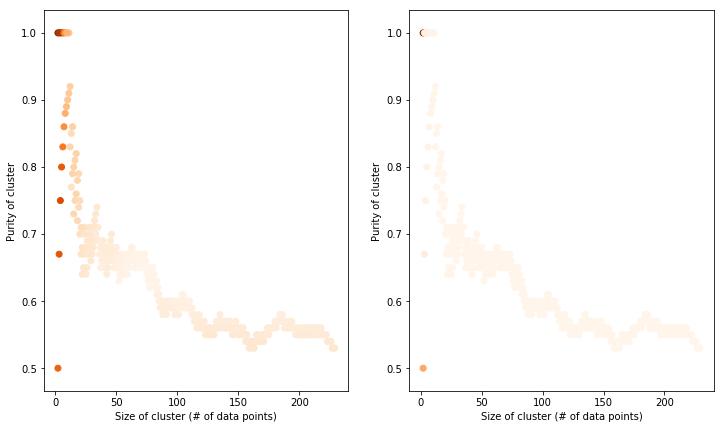

In [5]:
# analyze candidates of size N=2
if 0:
    cands = {c: (c.left_child, c.right_child) for c in all_candidates if c.N == 2}
    
    matches = []
    mismatches = []
    for n, (l, r) in cands.items():
        if l.index == r.index:
            matches.append(n)
        else:
            mismatches.append(n)

    merged_mtc = np.array([n.log_rk for n in matches])
    merged_mis = np.array([n.log_rk for n in mismatches])

    lml_mtc = np.array([n.log_pr_data_h1 for n in matches])
    lml_mis = np.array([n.log_pr_data_h1 for n in mismatches])

    bins = np.linspace(
        min(lml_mtc.min(), lml_mis.min()), max(lml_mtc.max(), lml_mis.max()), 20
    )
    h_mtc, _ = np.histogram(lml_mtc, bins=bins)
    h_mis, _ = np.histogram(lml_mis, bins=bins)

    f, ax = plt.subplots(figsize=(12, 7))

    for i, bs in enumerate(bins[:-1]):
        xs = [bs, bins[i+1]]

        p_mtc = h_mtc[i] / (h_mtc[i] + h_mis[i])

        ax.plot(xs, [p_mtc, p_mtc], color='green')
        ax.fill_between(xs, [p_mtc, p_mtc], color='green', alpha=0.4)
        ax.fill_between(xs, [1., 1.], [p_mtc, p_mtc], color='red', alpha=0.4)

    plt.show()

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7), sharex=True)

    # ax1.bar(bins[:-1], h_mtc)
    # ax2.bar(bins[:-1], h_mis)
    # # plt.legend()
    # plt.show()
    pass

# analyze candidates of all sizes
elif 1:
    info = defaultdict(list)
    # info[(N, purity)] = lml
    
    for node in all_candidates:
        _, cs = np.unique(node.index, return_counts=True)
        purity = np.round(cs.max() / len(node.index), 2)
        
        info[(node.N, purity)].append(node.log_pr_data_h1)

    for k, v in info.items():
        info[k] = (np.mean(v), np.var(v), len(v))

    info_arr = np.array([[N, P, M, V, S] for (N, P), (M, V, S) in info.items()])
    
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    for a in [ax1, ax2]:
        a.set_xlabel('Size of cluster (# of data points)')
        a.set_ylabel('Purity of cluster')
    
    normalize_by_N = False
    
    if normalize_by_N:
        for N in np.unique(info_arr[:, 0]):
            ix_N = np.argwhere(info_arr[:, 0] == N)
            if len(ix_N) > 1:
                mean_N = np.mean(info_arr[ix_N, 2])
                std_N = np.sqrt(np.var(info_arr[ix_N, 2]))
                
                info_arr[ix_N, 2] = (info_arr[ix_N, 2] - mean_N) / std_N
            else:
                info_arr[ix_N, 2] = 0.5
                
            
    xs_N = info_arr[:, 0]
    xs_P = info_arr[:, 1]
    
    lml_m = info_arr[:, 2]
    lml_v = info_arr[:, 3]
    lml_s = info_arr[:, 4]
    
    ss = None
    
    m_plot = ax1.scatter(xs_N, xs_P, c=lml_m, cmap=cm.Oranges, s=ss)
    v_plot = ax2.scatter(xs_N, xs_P, c=lml_v, cmap=cm.Oranges, s=ss)
    
#     plt.colorbar(m_plot, cax=ax1)
#     plt.colorbar(v_plot, cax=ax2)

    print(lml_m.max())
    print(info[(2, 1.00)])
    print(np.var(lml_v) / np.mean(lml_v))
    
    plt.show()
    

# Show tree

In [6]:
def show_tree(bhc):

    t = Tree()

    node2parent = {bhc.root: t}

    nodes = [bhc.root]
    
    tags = set(bhc.root.index)

    while len(nodes) > 0:
        node = nodes.pop(0)
        uniques, counts = np.unique(node.index, return_counts=True)
        purity = counts.max() / counts.sum()

        if len(node.index) > 1:
            name = 'n_k=%d; purity=%.2f; p=%.2f, lp=%.2f' \
                        % (len(node.index), purity, np.exp(node.log_rk), node.log_rk)
        else:
            name = '%s (%s)' % (node.index[0], node.tags['Geographic origin'])

        C = node2parent[node].add_child(name=name)

        if node.left_child is not None:
            assert node.right_child is not None

            nodes.extend([node.left_child, node.right_child])
            node2parent[node.left_child] = C
            node2parent[node.right_child] = C

    ts = TreeStyle()
    ts.show_leaf_name = False
    def my_layout(node):
        F = TextFace(node.name, tight_text=True)
        add_face_to_node(F, node, column=0, position="branch-right")
    ts.layout_fn = my_layout
    # t.render('out.svg', tree_style=ts)
    # ts.mode = 'c'

    t.show(tree_style=ts)
    
    return t
    
t = show_tree(bhc)
# t.render('tree_BinomialExperimental.pdf')


# Compare to traditional hierarchical clustering

In [ ]:
def calculate_purities_agg(agg_model, bhc, num_data, tag_key, take_averages=True):
    
    class Entry(object):
        def __init__(self, labels, tags, N=1, left=None, right=None):
            self.labels = labels
            for k, v in tags.items():
                if isinstance(v, str):
                    tags[k] = [v]
            self.tags = tags
            self.N = N
            
            self.is_root = self.N == num_data
            self.is_leaf = (left is None) and (right is None)
            
            self.left = left
            self.right = right
            
            self._depth = 0 if self.is_root else '?'
            
        @classmethod
        def merge(cls, left, right):
            labels = left.labels + right.labels
            N = left.N + right.N
            tags = dict()
            assert left.tags.keys() == right.tags.keys()
            for k in left.tags.keys():
                tags[k] = left.tags[k] + right.tags[k]

            return cls(labels, tags, N, left, right)
        
        @property
        def depth(self):
            if self._depth == '?':
                raise ValueError('Depth undefined/unknown...')
            else:
                return self._depth
            
        @depth.setter
        def depth(self, d):
            self._depth = d
            
        @property
        def purity(self):
            us, cs = np.unique(self.labels, return_counts=True)
            return cs.max() / len(self.labels)
        
        def tag_purity(self, k):
            us, cs = np.unique(self.tags[k], return_counts=True)
            return cs.max() / len(self.tags[k])
    
    
    tree = {
        i: Entry(bhc.leaves[i].index, bhc.leaves[i].tags) for i in range(num_data)
    }
    num_leaves = num_data
    num_internal = agg_model.children_.shape[0] # number of internal nodes
    num_nodes = num_leaves + num_internal
    
    ch = agg_model.children_

    for i, ix_node in enumerate(range(num_leaves, num_nodes)):
        tree[ix_node] = Entry.merge(tree[ch[i, 0]], tree[ch[i, 1]])
        
    root = [n for n in tree.values() if n.is_root][0]
    
    depth2purity = defaultdict(list)
    depth2tagpurity = defaultdict(list)
    
    size2purity = defaultdict(list)
    size2tagpurity = defaultdict(list)
    
    nodes = [root]
    while len(nodes) > 0:
        node = nodes.pop(0)
        
        p = node.purity
        tp = node.tag_purity(tag_key)
        
        depth2purity[node.depth].append(p)
        depth2tagpurity[node.depth].append(tp)
        
        size2purity[node.N].append(p)
        size2tagpurity[node.N].append(tp)
        
        if node.left is not None:
            assert node.right is not None, 'Tree not binary (?)'
    
            node.left.depth = node.depth + 1
            node.right.depth = node.depth + 1
            
            nodes.append(node.left)
            nodes.append(node.right)
    
    if take_averages:
        for out_dict in [depth2purity, depth2tagpurity, size2purity, size2tagpurity]:
            for k, ps in out_dict.items():
                out_dict[k] = np.mean(ps)
            
    return depth2purity, depth2tagpurity, size2purity, size2tagpurity

def calculate_purities_bhc(bhc, data, take_averages=True):

    def get_tags(self, k):
        if self.left_child is None:
            t = self.tags[k]
            out = [t] if isinstance(t, str) or not is_iterable(t) else t
            return out
        else:
            return get_tags(self.left_child, k) + get_tags(self.right_child, k)

    depth2purity = defaultdict(list)
    depth2tagpurity = defaultdict(list)
    
    size2purity = defaultdict(list)
    size2tagpurity = defaultdict(list)

    num_GOs = len(data['Geographic origin'].unique())
    num_regions = len(data['Region'].unique())

    nodes = [(bhc.root, 0)]
    while len(nodes) != 0:
        node, depth = nodes.pop(0)

        uniques, counts = np.unique(node.index, return_counts=True)
        purity = counts.max() / len(node.index)

        n_tags = get_tags(node, 'Geographic origin')
        u_tags, c_tags = np.unique(n_tags, return_counts=True)
        tag_purity = c_tags.max() / len(n_tags)

        depth2purity[depth].append(purity)
        depth2tagpurity[depth].append(tag_purity)
        
        size2purity[node.N].append(purity)
        size2tagpurity[node.N].append(tag_purity)

        if node.left_child is not None:
            nodes.append((node.left_child, depth+1))
            nodes.append((node.right_child, depth+1))

    if take_averages:
        for out_dict in [depth2purity, depth2tagpurity, size2purity, size2tagpurity]:
            for k, v in out_dict.items():
                out_dict[k] = np.mean(v)
        
    return depth2purity, depth2tagpurity, size2purity, size2tagpurity

def purity_plots(bhc_dicts, agg_dicts, show_diffs=False):
    
    class DictPLT(dict):
        """ ad hoc way to make plotting in this function easier """
        
        def __init__(self, d):
            super(DictPLT, self).__init__(d)
            self.is_normal_dict = True
            for k, v in d.items():
                if is_iterable(v):
                    self.is_normal_dict = False
                    break

        def keys(self):
            if self.is_normal_dict:
                return super(DictPLT, self).keys()
            else:
                k_out = []
                for k, v in self.items():
                    k_out.extend([k]*len(v))
                return k_out
            
        def values(self):
            if self.is_normal_dict:
                return super(DictPLT, self).values()
            else:
                v_out = []
                for k, v in self.items():
                    v_out.extend(v)
                return v_out
    
    ds = list(bhc_dicts+agg_dicts)
    for i in range(len(ds)):
        ds[i] = DictPLT(ds[i])
        
    
    
    d2p, d2tp, s2p, s2tp = ds[:4]
    d2p_g, d2tp_g, s2p_g, s2tp_g = ds[4:]
    
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
    axes = [ax1, ax2, ax3, ax4]
    for j, a in enumerate(axes):
        xlbl = 'Depth' if j in [0, 1] else 'Cluster Size'
        yqty = 'Region purity' if j in [0, 2] else 'Geographic origin purity'

        a.set_xlabel(xlbl)
        a.set_ylabel('Purity')
        a.set_title('%s vs. %s' % (yqty, xlbl))

    # axes 1 and 2
    if True:
        # ax1 ========================================
        xsr_BHC = list(d2p.keys())
        ysr_BHC = np.array(list(d2p.values()))
        ax1.scatter(xsr_BHC, ysr_BHC, color='red', label='BHC')

        xsr_AGG = list(d2p_g.keys())
        ysr_AGG = np.array(list(d2p_g.values()))
        ax1.scatter(xsr_AGG, ysr_AGG, color='blue', label='AGG')

        ax1.legend(*ax1.get_legend_handles_labels())
        
        if show_diffs:
            shared_xs = set(xsr_BHC).intersection(xsr_AGG)
            for x in shared_xs:
                y_BHC, y_AGG = ysr_BHC[x], ysr_AGG[x]
                c = 'red' if y_BHC > y_AGG else 'blue'
                ax1.plot([x, x], [y_BHC, y_AGG], color=c, alpha=0.5, zorder=5)

        # ax2 ========================================
        xsg_BHC = list(d2tp.keys())
        ysg_BHC = np.array(list(d2tp.values()))
        ax2.scatter(xsg_BHC, ysg_BHC, color='red', label='BHC')

        xsg_AGG = list(d2tp_g.keys())
        ysg_AGG = np.array(list(d2tp_g.values()))
        ax2.scatter(xsg_AGG, ysg_AGG, color='blue', label='AGG')

        ax2.legend(*ax2.get_legend_handles_labels())
        
        if show_diffs:
            shared_xs = set(xsg_BHC).intersection(xsg_AGG)
            for x in shared_xs:
                y_BHC, y_AGG = ysg_BHC[x], ysg_AGG[x]
                c = 'red' if y_BHC > y_AGG else 'blue'
                ax2.plot([x, x], [y_BHC, y_AGG], color=c, alpha=0.5, zorder=5)

    # axes 3 and 4
    if True:
        # ax3 ========================================
        s_ix = np.argsort(list(s2p.keys()))
        xsr_BHC = np.array(list(s2p.keys()))[s_ix]
        ysr_BHC = np.array(list(s2p.values()))[s_ix]
        ax3.scatter(xsr_BHC, ysr_BHC, color='red', label='BHC')

        s_ix = np.argsort(list(s2p_g.keys()))
        xsr_AGG = np.array(list(s2p_g.keys()))[s_ix]
        ysr_AGG = np.array(list(s2p_g.values()))[s_ix]
        ax3.scatter(xsr_AGG, ysr_AGG, color='blue', label='AGG')

        ax3.legend(*ax3.get_legend_handles_labels())
        
        if show_diffs:
            shared_xs = set(xsr_BHC).intersection(xsr_AGG)
            for x in shared_xs:
                x_BHC = np.argwhere(xsr_BHC == x).squeeze()
                x_AGG = np.argwhere(xsr_AGG == x).squeeze()
                y_BHC, y_AGG = ysr_BHC[x_BHC], ysr_AGG[x_AGG]
                c = 'red' if y_BHC > y_AGG else 'blue'
                ax3.plot([x, x], [y_BHC, y_AGG], color=c, alpha=0.5, zorder=5)

        # ax4 ========================================
        s_ix = np.argsort(list(s2tp.keys()))
        xsg_BHC = np.array(list(s2tp.keys()))[s_ix]
        ysg_BHC = np.array(list(s2tp.values()))[s_ix]
        ax4.scatter(xsg_BHC, ysg_BHC, color='red', label='BHC')

        s_ix = np.argsort(list(s2tp_g.keys()))
        xsg_AGG = np.array(list(s2tp_g.keys()))[s_ix]
        ysg_AGG = np.array(list(s2tp_g.values()))[s_ix]
        ax4.scatter(xsg_AGG, ysg_AGG, color='blue', label='AGG')

        ax4.legend(*ax4.get_legend_handles_labels())
        
        if show_diffs:
            shared_xs = set(xsg_BHC).intersection(xsg_AGG)
            for x in shared_xs:
                x_BHC = np.argwhere(xsg_BHC == x).squeeze()
                x_AGG = np.argwhere(xsg_AGG == x).squeeze()
                y_BHC, y_AGG = ysg_BHC[x_BHC], ysg_AGG[x_AGG]
                c = 'red' if y_BHC > y_AGG else 'blue'
                ax4.plot([x, x], [y_BHC, y_AGG], color=c, alpha=0.5, zorder=5)

    plt.show()



In [ ]:
agg_model = AgglomerativeClustering(n_clusters=1).fit(D)

purities_bhc = calculate_purities_bhc(bhc, data, take_averages=False)
purities_agg = calculate_purities_agg(
    agg_model, bhc, D.shape[0], 'Geographic origin', take_averages=False
)   

purity_plots(purities_bhc, purities_agg)

# prior distribution plotting

In [ ]:
a = 1.
b = 1.

xs = np.arange(0.01, 1., 0.01)
ys = beta_dist.pdf(xs, a, b)
ys /= np.sum(ys)

f, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_ylim([0., 0.1])
ax.set_xlabel(r'$p$ (Bernoulli parameter)')
ax.set_ylabel(r'$Pr(p | \alpha=%.2f, \beta=%.2f)$' % (a, b))
plt.show()

# Testing

In [ ]:

if 0:
    results = []
    samples_JPN = []
    lps_JPN = []
    samples_MIX = []
    lps_MIX = []
    for _ in tqdm(range(50)):

        # model = BetaBinomial(alpha=1., beta=1.)
        # model = BinomialMLE()
        model = BetaPriorMC(alpha=3., beta=3.)
        crp_alpha = 1.

        # c_i = np.random.randint(0, 10)
        # j_i1, j_i2 = np.random.choice(10, replace=False, size=2)
        # print(c_i, j_i1, j_i2)
        c_i = 0
        j_i1, j_i2 = 0, 1

        # D1 = data.values[0, :50].astype(np.int8).reshape(1, -1)
        d_CAR = data[data['Geographic origin'] == 'Central African Republic'].values[c_i, :50].reshape(1, -1).astype(np.int8)
        n_CAR = Leaf(d_CAR, crp_alpha, model)

        # D2 = data.values[1, :50].astype(np.int8).reshape(1, -1)
        d_JPN = data[data['Geographic origin'] == 'Japan'].values[j_i1, :50].reshape(1, -1).astype(np.int8)
        n_JPN = Leaf(d_JPN, crp_alpha, model)

        # D3 = data.values[500, :50].astype(np.int8).reshape(1, -1) 
        d_JPN2 = data[data['Geographic origin'] == 'Japan'].values[j_i2, :50].reshape(1, -1).astype(np.int8)
        n_JPN2 = Leaf(d_JPN2, crp_alpha, model)

        LL_CAR = n_CAR.log_pr_data_tk
        LL_JPN = n_JPN.log_pr_data_tk
        LL_JPN2 = n_JPN2.log_pr_data_tk



        N_JPN = Node.merge(n_JPN, n_JPN2)
        N_MIX = Node.merge(n_JPN, n_CAR)

        results.append((np.exp(N_JPN.log_rk), np.exp(N_MIX.log_rk)))
        samples_JPN.append(N_JPN.samples)
        samples_MIX.append(N_MIX.samples)
        lps_JPN.append(N_JPN.log_pr_data_h1)
        lps_MIX.append(N_MIX.log_pr_data_h1)


    results = np.array(results)
    h1, b1 = np.histogram(results[:, 0], bins=np.linspace(0, 1, 10))
    h2, b2 = np.histogram(results[:, 1], bins=np.linspace(0, 1, 10))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)
    ax1.bar(b1[:-1], h1)
    ax2.bar(b2[:-1], h2)
    ax1.set_title('JPN')
    ax2.set_title('MIX')
    plt.show()
    

if 0:
    # model = BetaBinomial(alpha=1., beta=1.)
    # model = BinomialMLE()
    model = BetaPriorMC(alpha=3., beta=3.)
    crp_alpha = 1.

    # c_i = np.random.randint(0, 10)
    # j_i1, j_i2 = np.random.choice(10, replace=False, size=2)
    # print(c_i, j_i1, j_i2)
    c_i = 0
    j_i1, j_i2 = 0, 1

    # D1 = data.values[0, :50].astype(np.int8).reshape(1, -1)
    d_CAR = data[data['Geographic origin'] == 'Central African Republic'].values[c_i, :50].reshape(1, -1).astype(np.int8)
    n_CAR = Leaf(d_CAR, crp_alpha, model)

    # D2 = data.values[1, :50].astype(np.int8).reshape(1, -1)
    d_JPN = data[data['Geographic origin'] == 'Japan'].values[j_i1, :50].reshape(1, -1).astype(np.int8)
    n_JPN = Leaf(d_JPN, crp_alpha, model)

    # D3 = data.values[500, :50].astype(np.int8).reshape(1, -1) 
    d_JPN2 = data[data['Geographic origin'] == 'Japan'].values[j_i2, :50].reshape(1, -1).astype(np.int8)
    n_JPN2 = Leaf(d_JPN2, crp_alpha, model)

    LL_CAR = n_CAR.log_pr_data_tk
    LL_JPN = n_JPN.log_pr_data_tk
    LL_JPN2 = n_JPN2.log_pr_data_tk



    N_JPN = Node.merge(n_JPN, n_JPN2)
    N_MIX = Node.merge(n_JPN, n_CAR)
    
    # print('P(D_i | H_1^i):', LL_CAR, LL_JPN, LL_JPN2)
    # print('P(D_k | H_1^k):', N_JPN.log_pr_data_h1, N_MIX.log_pr_data_h1)
    # print('P(D_k | T_k):  ', N_JPN.log_pr_data_tk, N_MIX.log_pr_data_tk)
    # print('P(H_1^k | D_k):', np.exp(N_JPN.log_rk), np.exp(N_MIX.log_rk))


    print('JAPAN NODE')
    print('P(D_i | H_1^i):', LL_JPN, LL_JPN2)
    print('P(D_k | H_1^k):', N_JPN.log_pr_data_h1)
    print('P(D_k | T_k):  ', N_JPN.log_pr_data_tk)
    print('P(H_1^k | D_k):', np.exp(N_JPN.log_rk))

    print('')
    print('MIXED NODE')
    print('P(D_i | H_1^i):', LL_JPN, LL_CAR)
    print('P(D_k | H_1^k):', N_MIX.log_pr_data_h1)
    print('P(D_k | T_k):  ', N_MIX.log_pr_data_tk)
    print('P(H_1^k | D_k):', np.exp(N_MIX.log_rk))
    
if 1:
    d2pi = defaultdict(list)
    n2pi = defaultdict(list)
    pi_n = defaultdict(list)
    
    d2ph1 = defaultdict(list)
    n2ph1 = defaultdict(list)
    ph1_n = defaultdict(list)
    
    nodes = [(bhc.root, 0)]
    while len(nodes) > 0:
        node, depth = nodes.pop(0)
        
        pi = np.exp(node.log_pi)
        
        d2pi[depth].append(pi)
        d2ph1[depth].append(node.log_pr_data_h1)
        
        n2pi[node.N].append(pi)
        n2ph1[node.N].append(node.log_pr_data_h1)
        
        nl, nr = node.left_child, node.right_child
        if nl is not None and nr is not None:
            X_n = (nl.N, nr.N)
            pi_n[X_n].append(pi)
            ph1_n[X_n].append(node.log_pr_data_h1)
            
            nodes.extend([(nl, depth+1) , (nr, depth+1)])
            
    for od in [d2pi, n2pi, d2ph1, n2ph1, pi_n, ph1_n]:
        for k, v in od.items():
            od[k] = [np.mean(v), np.var(v)]
     
    # =======================================================
    to_plt = n2ph1
            
    xs = list(to_plt.keys())
    ys = np.array(list(to_plt.values()))
#     print(ys.shape, ys.dtype, ys)
    ym = ys[:, 0]
    yv = ys[:, 1]
            
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
#     ax1.contourf(ds)
    ax1.scatter(xs, ym)
    ax2.scatter(xs, yv)
    plt.show()

In [ ]:
# f, ax = plt.subplots()
# ax.scatter(range(50), results[:, 0])
# plt.show()

split = 0.6
idx_g = np.argwhere(results[:, 0] > split).squeeze()
idx_b = np.argwhere(results[:, 0] <= split).squeeze()

LP_good = np.array(lps_JPN)[idx_g]
RK_good = results[idx_g, 0]
LP_bad = np.array(lps_JPN)[idx_b]
RK_bad = results[idx_b, 0]

s_JPN = sorted(lps_JPN)
m1, m2 = s_JPN[24], s_JPN[25]
s_RK = sorted(results[:, 0])
r1, r2 = s_RK[24], s_RK[25]
RK_med = (r1 + r2) / 2.
LP_med = np.median(lps_JPN)

print(LP_med.shape, RK_med.shape)

plt.scatter(LP_good, RK_good, label='good')
plt.scatter(LP_bad, RK_bad, label='bad')
plt.scatter([LP_med], [RK_med], label='median')
plt.legend()
plt.show()
    